In [1]:
import pandas as pd
import numpy as np
import matplotlib

#### Import the ipo info file, which has ipo first trade date:

In [2]:
ipo_info_file_path = 'data/raw/IPO_Info.csv'
ipo_info_df = pd.read_csv(ipo_info_file_path)

In [3]:
ipo_info_df.head()

,Symbol,IPO Date,Offer Price,Sector,Industry,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,AGRO,1/28/2011,11.0,AGRICULTRE,Agricultural Operations,NaN,NaN,NaN,NaN
1,BKU,1/28/2011,27.0,S&Ls,Finance-Savings & Loan,NaN,NaN,NaN,NaN
2,INXN,1/28/2011,13.0,INTERNET,Internet-Network Sltns,NaN,NaN,NaN,NaN
3,NPTN,2/2/2011,11.0,ELECTRNCS,Electronic-Parts,NaN,NaN,NaN,NaN
4,FLDM,2/10/2011,13.5,MEDICAL,Medical-Systems/Equip,NaN,NaN,NaN,NaN


#### Remove extra columns 

In [4]:
ipo_info_df.drop(ipo_info_df.iloc[:, 5:9], axis=1, inplace=True)

In [5]:
ipo_info_df.head()

,Symbol,IPO Date,Offer Price,Sector,Industry
0,AGRO,1/28/2011,11.0,AGRICULTRE,Agricultural Operations
1,BKU,1/28/2011,27.0,S&Ls,Finance-Savings & Loan
2,INXN,1/28/2011,13.0,INTERNET,Internet-Network Sltns
3,NPTN,2/2/2011,11.0,ELECTRNCS,Electronic-Parts
4,FLDM,2/10/2011,13.5,MEDICAL,Medical-Systems/Equip


#### Convert date column to proper date type:

In [6]:
ipo_info_df['IPO Date'] = pd.to_datetime(ipo_info_df['IPO Date'])

In [7]:
ipo_info_df.head()

,Symbol,IPO Date,Offer Price,Sector,Industry
0,AGRO,2011-01-28,11.0,AGRICULTRE,Agricultural Operations
1,BKU,2011-01-28,27.0,S&Ls,Finance-Savings & Loan
2,INXN,2011-01-28,13.0,INTERNET,Internet-Network Sltns
3,NPTN,2011-02-02,11.0,ELECTRNCS,Electronic-Parts
4,FLDM,2011-02-10,13.5,MEDICAL,Medical-Systems/Equip


#### Import the IPO end of day data file:

In [8]:
ipo_eod_data_file_path = 'data/raw/EOD_Data.csv'
ipo_eod_data_df = pd.read_csv(ipo_eod_data_file_path)

In [9]:
ipo_eod_data_df.head()

,Symbol,Date,Open,High,Low,Close,Volume,VWAP
0,AAAP,11/11/2015,18.50,25.90,18.00,24.50,1584639.0,20.1547
1,AAAP,1/28/2016,23.71,25.08,23.01,23.81,310937.0,23.6635
2,AAAP,1/26/2016,25.00,25.11,20.53,24.86,53747.0,23.6999
3,AAAP,1/29/2016,23.19,24.97,23.18,24.88,60790.0,23.9222
4,AAAP,2/9/2016,24.00,25.23,23.89,24.06,23039.0,24.4341


In [10]:
%%time
ipo_eod_data_df['Date'] = pd.to_datetime(ipo_eod_data_df['Date'])

Wall time: 1min 32s


In [11]:
ipo_eod_data_df.head()

,Symbol,Date,Open,High,Low,Close,Volume,VWAP
0,AAAP,2015-11-11,18.50,25.90,18.00,24.50,1584639.0,20.1547
1,AAAP,2016-01-28,23.71,25.08,23.01,23.81,310937.0,23.6635
2,AAAP,2016-01-26,25.00,25.11,20.53,24.86,53747.0,23.6999
3,AAAP,2016-01-29,23.19,24.97,23.18,24.88,60790.0,23.9222
4,AAAP,2016-02-09,24.00,25.23,23.89,24.06,23039.0,24.4341


In [12]:
ipo_info_df['Symbol'].count()

917

In [13]:
# a structure to store execution data
execution = {
    'quantity':0,
    'symbol':'',
    'price':0.0,
    'date':''
}

# a strcuture to store daily returns for equity curve
daily_returns = {
    'date':'',
    'pnl':0.0
}

In [14]:
class moving_average:
    
    def __init__(self, length):
        self.length = length
        self.value_queue = []
        
    def add_val(self, val):
        self.value_queue.append(val)
        if len(self.value_queue) > self.length:
            self.value_queue.pop(0)
            
    def current_val(self):
        return sum(self.value_queue)/float(len(self.value_queue))
    
    def get_length(self):
        return len(self.value_queue)
    
    def __delitem__(self):
        self.value_queue[:] = []
    

In [64]:
# this version uses moving average for the stop
def backtest_symbol(symbol, start_date):
    
    
    # get the price data starting from IPO Date sorted by date
    price_data = ipo_eod_data_df[(ipo_eod_data_df.Symbol==symbol) & (ipo_eod_data_df.Date >= start_date)].sort_values(by=['Date'])
    
    days_since_ipo = 0
    all_time_high = 0.0
    low0 = 99990.0
    low1 = 99990.0
    low2 = 99990.0
    low3 = 99990.0
    DOLLAR_PER_POSITION = 10000
    
    entry_triggered = False
    
    execution_list = []
    daily_returns_list = []
    position = 0
    previous_close = 0
    entry_date = ''
    ma = moving_average(5)
    
    # iterate through the days starting with ipo date
    for index, row in price_data.iterrows():
        if entry_triggered:
            position = int(DOLLAR_PER_POSITION/previous_close)
            execution_list.append({'Quantity':position,'Symbol':symbol,'Price':row['VWAP'],'Date':row['Date']})
            entry_date = row['Date']
            entry_triggered = False
        
              
        
        days_since_ipo += 1
        
        new_high = False
        if row['High'] > all_time_high: 
            all_time_high = row['High']
            new_high = True
            
        # update 3 day low
        low3 = low2
        low2 = low1
        low1 = low0
        low0 = row['Low']
        
        three_day_low = min(low1,low2,low3)
        
        # check if entry triggered
        if (position == 0
            and days_since_ipo > 5 
            and new_high):
            entry_triggered = True 
            #note: will enter next day vwap
            
        # check if stopped out
        if position != 0:
            if (row['Low'] < ma.current_val()
                and entry_triggered == False):
                execution_list.append({'Quantity':(position*-1),'Symbol':symbol,'Price':ma.current_val(),'Date':row['Date']})
                daily_returns_list.append({'Date':row['Date'],'pnl':((ma.current_val() - previous_close) * position)})
                position = 0
            else:
                # record daily returns
                change = 0.0
                if entry_date == row['Date']:
                    # today was the entry
                    change = row['Close'] - row['VWAP']
                else:
                    change = row['Close'] - previous_close
                
                daily_returns_list.append({'Date':row['Date'],'pnl':(change * position)})
                
        # update moving avg
        ma.add_val(row['Close'])  
            
        previous_close = row['Close']
        
              
    executions_df = pd.DataFrame(execution_list)
    daily_returns_df = pd.DataFrame(daily_returns_list)
        
    return (executions_df,daily_returns_df)

#### Test 1 Symbol

In [65]:
result_tuple = backtest_symbol('ROKU','2017-09-28')

Trades in ROKU:

In [66]:
result_tuple[0]

,Date,Price,Quantity,Symbol
0,2017-11-13,41.2980,300,ROKU
1,2017-11-17,38.4040,-300,ROKU
2,2017-11-29,45.2236,215,ROKU
3,2017-11-30,43.5780,-215,ROKU
4,2017-12-18,55.5069,191,ROKU
5,2017-12-21,52.8060,-191,ROKU


Roku daily returns:

In [67]:
result_tuple[1]

,Date,pnl
0,2017-11-13,423.6000
1,2017-11-14,-1728.0000
2,2017-11-15,711.0000
3,2017-11-16,141.0000
4,2017-11-17,-415.8000
5,2017-11-29,-76.0240
6,2017-11-30,-277.7800
7,2017-12-18,113.2821
8,2017-12-19,91.6800
9,2017-12-20,-704.7900


#### Test All Stocks and time execution:

In [68]:
%%time
# iterate through the symbol list
all_executions = None
all_returns = None
for index, row in ipo_info_df.iterrows():
    
    symbol = row['Symbol']
    start_date = row['IPO Date']
    
    results = backtest_symbol(symbol, start_date)
    
    if all_executions is None:
        all_executions = results[0]
        all_returns = results[1]
    else:
        all_executions = pd.concat([all_executions, results[0]])
        all_returns = pd.concat([all_returns, results[1]])
sorted_returns = all_returns.sort_values(['Date'])
returns = sorted_returns.groupby(['Date'])['pnl'].sum()   
cumulative_sums = returns.cumsum()
all_executions['abs_shares'] = abs(all_executions['Quantity'])
shares_traded = all_executions.abs_shares.sum()
gross = all_returns.sum()
commission = shares_traded * .007
net = gross - commission
cps = gross / shares_traded

Wall time: 1min 31s


In [72]:
%matplotlib inline

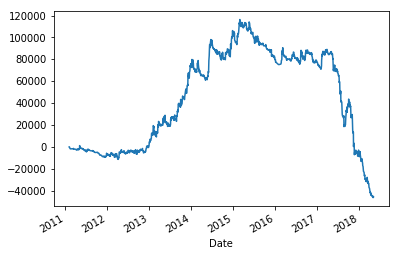

In [73]:
cumulative_sums.plot.line()

In [76]:
shares_traded

4089503

In [77]:
gross

pnl   -45771.835
dtype: float64

In [78]:
commission

28626.521

In [79]:
net

pnl   -74398.356
dtype: float64

In [81]:
cps

pnl   -0.011193
dtype: float64